# Import required libraries
In order to analysing text data, some libraries are needed
+ **re**: The re module provides a set of powerful regular expression facilities, which allows you to quickly check whether a given string matches a given pattern (using the match function), or contains such a pattern (using the search function).
+ **ast**: The ast module helps Python applications to process trees of the Python abstract syntax grammar. The abstract syntax itself might change with each Python release; this module helps to find out programmatically what the current grammar looks like. An abstract syntax tree can be generated by passing ast.
+ **emot**: The EMOT Library allows users to analyze emoji usage on a large scale. For example, we could use the EMOT library to identify the emoji usage of different Twitter users. 
+ **nltk**: The Natural Language Toolkit (NLTK) is a platform used for building Python programs that work with human language data for applying in statistical natural language processing (NLP). It contains text processing libraries for tokenization, parsing, classification, stemming, tagging and semantic reasoning
+ **Numpy**: A Python library for numerical computing, providing powerful array and matrix operations for scientific computing tasks.
+ **Pandas**: A popular data analysis library for Python, providing powerful data structures and tools for working with structured data such as CSV files, SQL databases, and more.

In [150]:
import re
import ast
import emot
import nltk
import numpy as np
import pandas as pd
from nltk.sentiment import SentimentIntensityAnalyzer

In [31]:
def replace_emoji(text):
    emot_obj = emot.core.emot()
    emotes = emot_obj.emoji(text)
    for i in range(len(emotes['value'])):
        text = text.replace(emotes['value'][i], emotes['mean'][i])
    return text


def normalize(text):
    link_pattern = r"https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)"
    text = re.sub(link_pattern, '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    text = replace_emoji(text)
    text = text.replace('\n',' ')
    return text


In [139]:
data = pd.read_csv("twitter-scraper/scraped_tweets_missingbaby.csv")

In [47]:
data.head()

,Unnamed: 0,username,description,location,following,followers,totaltweets,retweetcount,link,text,hashtags
0,0,JISTLAB_,⛅️ 🇨🇦🇲🇦 IG ~ JISTLAB,"Montréal, Québec",160,135,48087,22,https://twitter.com/i/web/status/1632739441830...,"Runaway British Mum, Constance Marten, Charged...",[]
1,1,Abdul42920472,NaN,NaN,68,2,310,26,https://twitter.com/i/web/status/1632735132611...,Detectives continue to quiz Constance Marten a...,[]
2,2,VaclavusU,"US,UK,World Politics,ShowBiz,Sport Celebrities...","SE 256th street Kent, WA, USA",54,17,24121,0,https://twitter.com/i/web/status/1632731896047...,Constance Marten and Mark Gordon blow each oth...,[]
3,3,VaclavusU,"US,UK,World Politics,ShowBiz,Sport Celebrities...","SE 256th street Kent, WA, USA",54,17,24121,0,https://twitter.com/i/web/status/1632731355392...,Constance Marten and Mark Gordon named baby be...,[]
4,4,colinwitcher,Barrister specialising in General Crime and Bu...,"London, England",1649,2524,2234,1,https://twitter.com/i/web/status/1632721208163...,Lewis Power KC and @colinwitcher instructed on...,[]


In [34]:
analyzer = SentimentIntensityAnalyzer()

# Define a dictionary to map the sentiment scores to emotions
emotion_dict = {'angry':0,
               'upset': 0,
               'nutural':0,
               'curious':0,
               'happy':0}

all_scores = []

# Loop through each tweet and determine the emotion
for tweet in tweets:
    # Get the sentiment score for the tweet
    sentiment_score = analyzer.polarity_scores(normalize(tweet))
    all_scores.append(sentiment_score)
    # Determine the emotion based on the sentiment score
    
    if sentiment_score['neg'] > sentiment_score['pos']:
        if sentiment_score['neg'] > sentiment_score['neu']:
            emotion_dict['angry'] += 1
        else:
            emotion_dict['upset'] += 1
            
            
    elif sentiment_score['pos'] > sentiment_score['neg']:
        if sentiment_score['pos'] > sentiment_score['neu']:
            emotion_dict['happy'] += 1
        else:
            emotion_dict['curious'] += 1
            
            
    else:
        if sentiment_score['neu'] > 0.5:
            emotion_dict['nutural'] += 1

In [35]:
# Print the count of each emotion
for emotion, count in emotion_dict.items():
    print(f"{emotion}: {count}")

angry: 131
upset: 7186
nutural: 1182
curious: 1286
happy: 16


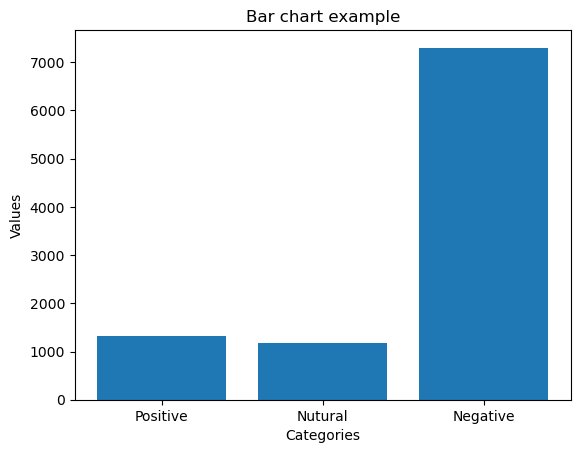

In [36]:
compound_scores = []
for tweet_scores in all_scores:
    compound_scores.append(tweet_scores['compound'])
    
scores = np.array(compound_scores)

x = np.array(['Positive', 'Nutural', 'Negative'])
y = np.array([np.sum(scores > 0), np.sum(scores == 0), np.sum(scores < 0)])

# Create bar chart
plt.bar(x, y)

# Add labels and title
plt.xlabel('Categories')
plt.ylabel('Values')
plt.title('Bar chart example')

# Show chart
plt.show()

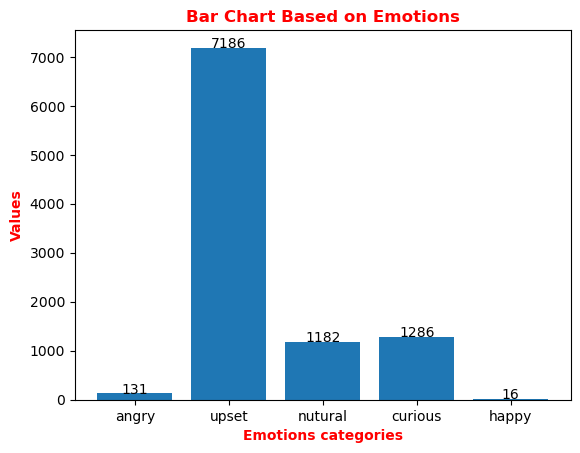

In [46]:
compound_scores = []
for tweet_scores in all_scores:
    compound_scores.append(tweet_scores['compound'])
    
scores = np.array(compound_scores)

x = np.array([emotion for emotion in emotion_dict.keys()])
y = np.array([emotion[1] for emotion in emotion_dict.items()])

# Create bar chart
plt.bar(x, y)

# Write the number of each bar above it
for i, v in enumerate(y):
    plt.text(i, v + 0.2, str(v), ha='center')

# Add labels and title
plt.xlabel('Emotions categories', fontweight="bold", color="red")
plt.ylabel('Values', fontweight="bold", color="red")
plt.title('Bar Chart Based on Emotions', fontweight="bold", color="red")

# Show chart
plt.show()


In [70]:


hashtags = []
for tags_list in data['hashtags']:
    if tags_list != '[]':
        tag_list = ast.literal_eval(tags_list)
        for hashtag in tag_list:
            hashtags.append(hashtag)

hashtags = np.array(hashtags)

In [90]:
unique, counts = np.unique(hashtags, return_counts=True)
hashtag_dict = {'hashtags':unique, 'counts':counts}

In [93]:
hashtags_table = pd.DataFrame(hashtag_dict).sort_values(by='counts', ascending=False)

In [153]:
hashtags_table.head(10)

,hashtags,counts
203,constancemarten,158
26,Brighton,116
40,ConstanceMarten,103
22,Breaking,70
93,MarkGordon,66
159,UPDATE,48
285,news,39
14,BREAKING,34
39,Constance,30
82,London,28


In [103]:
data.sort_values(by='followers', ascending=False)[['username', 'followers']].drop_duplicates(subset='username').head(20)

,username,followers
4018,cnnbrk,64195142
4068,CNN,61267702
2797,BBCBreaking,51682355
947,BBCWorld,39609526
5450,BBCNews,15060185
4066,cnni,14473199
7978,HuffPost,11204819
9730,guardian,10895482
8140,CBSNews,8918937
9455,SkyNews,8371899


In [149]:
locations = data.drop_duplicates(subset='username')['location']

In [151]:
processed_locations = []
for location in locations:
    if type(location) == str:
        location = replace_emoji(location)
        location.split(', ')
        processed_locations.append(location)